In [3]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [4]:
import h5py
import numpy
import matplotlib.pyplot as plt

In [5]:
import torchvision.datasets

In [ ]:
#mnist_dataset = torchvision.datasets.CelebA(root='.', download=True)

In [6]:
import zipfile
import imageio
import os

In [ ]:
%%time

hdf5_file = 'mount/My Drive/Colab Notebooks/myo_gan/celeba_dataset/celeba_aligned_small.h5py'

total_images = 20000

with h5py.File(hdf5_file, 'w') as hf:
  count = 0

  with zipfile.ZipFile('mount/My Drive/Colab Notebooks/myo_gan/celeba/img_align_celeba_20000.zip', 'r') as zf:
    for i in zf.namelist():
      if(i[-4:] == '.jpg'):
        ofile = zf.extract(i)
        img = imageio.imread(ofile)
        os.remove(ofile)

        hf.create_dataset('img_align_celeba/' + str(count)+'.jpg', data = img, compression = "gzip", compression_opts = 9)

        count = count +1
        if(count % 1000 == 0):
          print("images done ..", count)
          pass

        if(count == total_images):
          break
        pass

      pass

    pass

In [7]:
with h5py.File('mount/My Drive/Colab Notebooks/myo_gan/celeba_dataset/celeba_aligned_small.h5py', 'r') as file_object:

  for group in file_object:
    print(group)
    pass

img_align_celeba


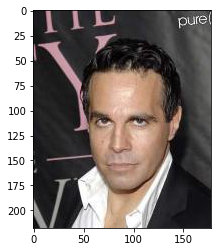

In [8]:
with h5py.File('mount/My Drive/Colab Notebooks/myo_gan/celeba_dataset/celeba_aligned_small.h5py', 'r') as file_object:
  dataset = file_object['img_align_celeba']
  image = numpy.array(dataset['7.jpg'])
  plt.imshow(image, interpolation='none')
  pass

In [9]:
image.shape

(218, 178, 3)

In [21]:
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import pandas

In [11]:
class CelebADataset(Dataset):
  def __init__(self, file):
    self.file_object = h5py.File(file, 'r')
    self.dataset = self.file_object['img_align_celeba']
    pass

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    if(index >= len(self.dataset)):
      raise IndexError()
    img = numpy.array(self.dataset[str(index)+'.jpg'])
    return torch.cuda.FloatTensor(img) / 255.0

  def plot_image(self, index):
    plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
    pass
  
  pass

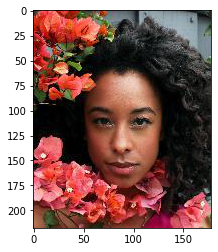

In [13]:
celeba_dataset = CelebADataset('mount/My Drive/Colab Notebooks/myo_gan/celeba_dataset/celeba_aligned_small.h5py')

celeba_dataset.plot_image(43)

In [14]:
#GPU설정
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda: ", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda:  Tesla K80


device(type='cuda')

In [26]:
#Veiw함수
class View(nn.Module):
  def __init__(self, shape):
    super().__init__()
    self.shape = shape,

  def forward(self, x):
    return x.view(*self.shape)

In [16]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        View(218*178*3),#3차원 텐서를 1차원 형태의 텐서로 바꿔주는 역할

        nn.Linear(3*218*178, 100), 
        nn.LeakyReLU(),

        nn.LayerNorm(100),

        nn.Linear(100, 1),
        nn.Sigmoid()
    )

    self.loss_function = nn.BCELoss()

    self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

    self.counter = 0
    self.progress = []

    pass

  def forward(self, inputs):
    return self.model(inputs)

  def train(self, inputs, targets):
    outputs = self.forward(inputs)

    loss = self.loss_function(outputs, targets)

    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if(self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim=(0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.25, 0.5, 1.0, 5.0))
    pass

In [17]:
def generate_random_image(size):
  random_data = torch.rand(size)
  return random_data

def generate_random_seed(size):
  random_data = torch.randn(size)
  return random_data

In [19]:
%%time

D = Discriminator()
D.to(device)#신경망을 포함하는 판별기 객체 D를 GPU로 변환하는 과정

for image_data_tensor in celeba_dataset:
  D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
  D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))
  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
CPU times: user 5min 45s, sys: 5.79 s, total: 5min 51s
Wall time: 5min 51s


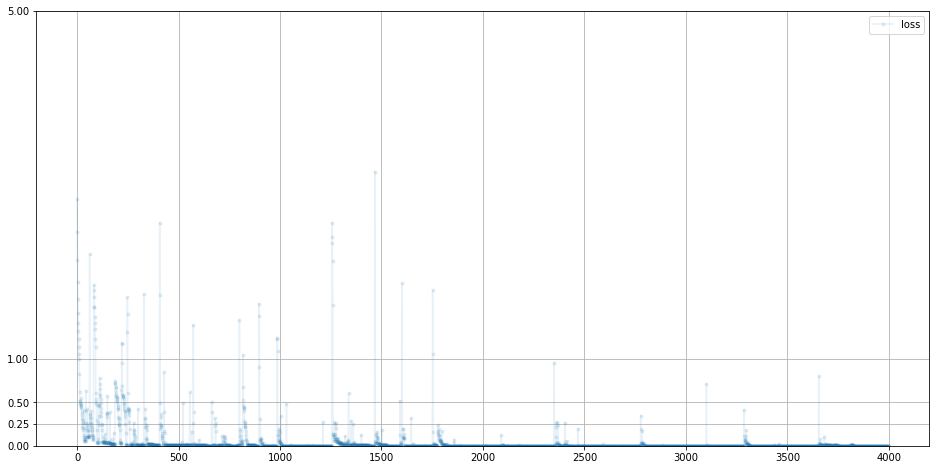

In [22]:
D.plot_progress()

In [28]:
#생성기
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(100, 3*10*10), 
        nn.LeakyReLU(),

        nn.LayerNorm(3*10*10),

        nn.Linear(3*10*10, 3*218*178),
        nn.Sigmoid(),

        View((218, 178, 3))
    )

    self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001)

    self.counter = 0
    self.progress = []

    pass

  def forward(self, inputs):
    return self.model(inputs)

  def train(self, D, inputs, targets):
    g_output = self.forward(inputs)

    d_output = D.forward(g_output)

    loss = D.loss_function(d_output, targets)

    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim=(0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.25, 0.5, 1.0, 5.0))
    pass

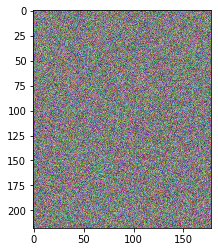

In [29]:
G = Generator()
G.to(device)#모델을 CUDA에 배치

output = G.forward(generate_random_seed(100))
img = output.detach().cpu().numpy()
plt.imshow(img, interpolation = 'none', cmap='Blues')

In [30]:
%%time
D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

epochs = 1

for epoch in range(epochs):
  print("epoch = ", epoch + 1)

  for image_data_tensor in celeba_dataset:
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass

  pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
CPU times: user 15min 21s, sys: 8.25 s, total: 15min 29s
Wall time: 15min 26s


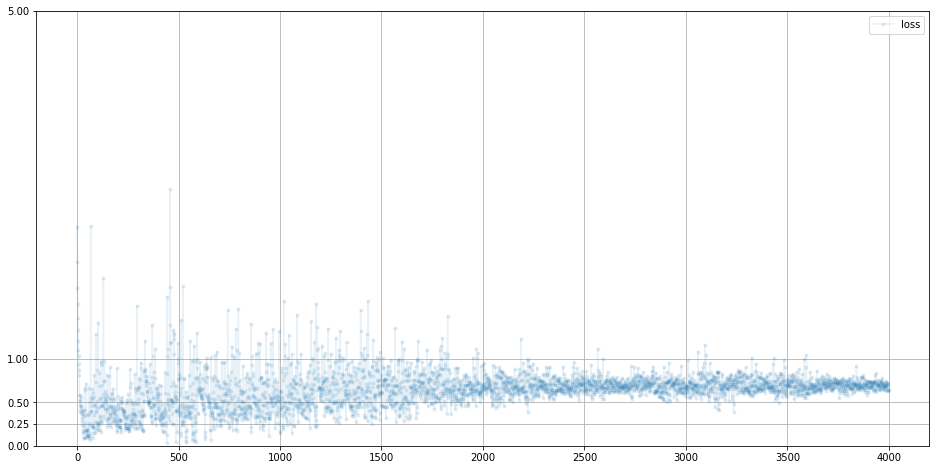

In [31]:
D.plot_progress()

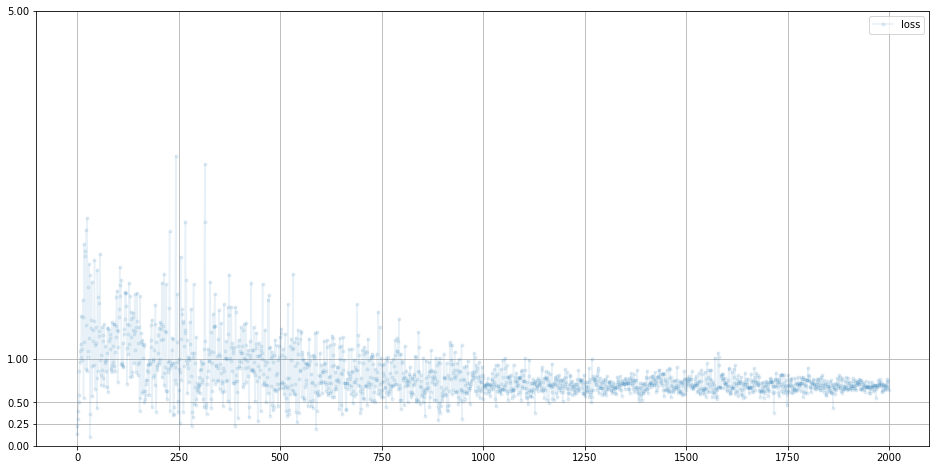

In [32]:
G.plot_progress()

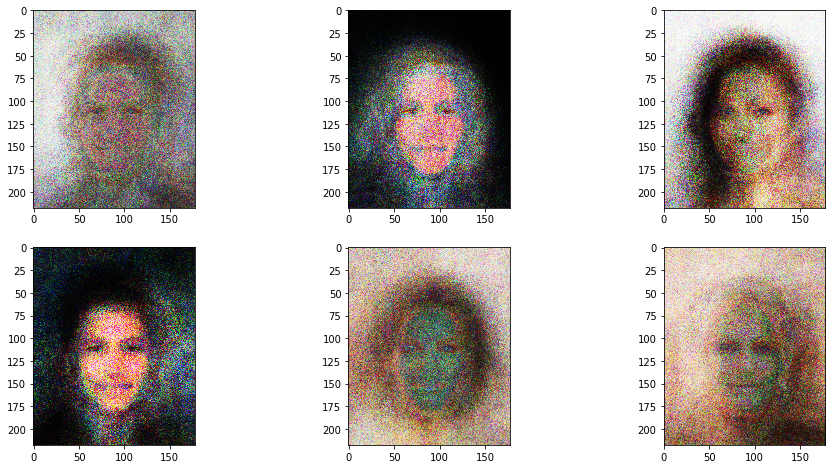

In [33]:
f, axarr = plt.subplots(2, 3, figsize = (16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().cpu().numpy()
    axarr[i, j].imshow(img, interpolation='none', cmap='Blues')
    pass
  pass

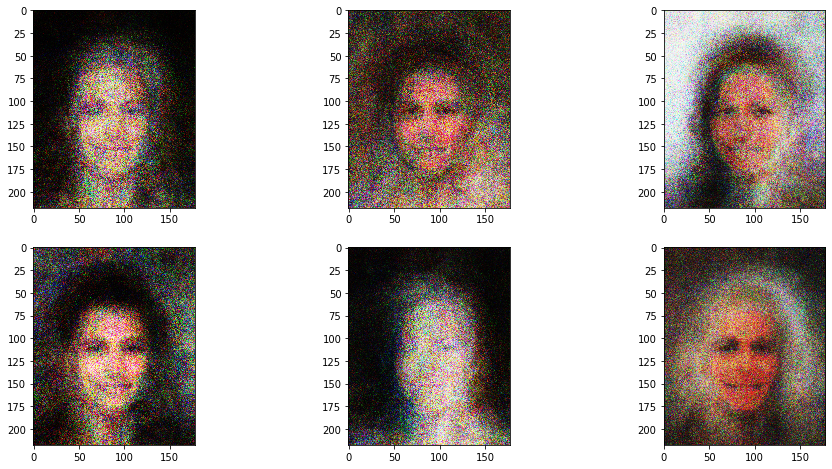

In [34]:
f, axarr = plt.subplots(2, 3, figsize = (16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random_seed(100))
    img = output.detach().cpu().numpy()
    axarr[i, j].imshow(img, interpolation='none', cmap='Blues')
    pass
  pass

In [ ]:
#D.plot_progress()

In [ ]:
#G.plot_progress()